The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: Row must be a int.

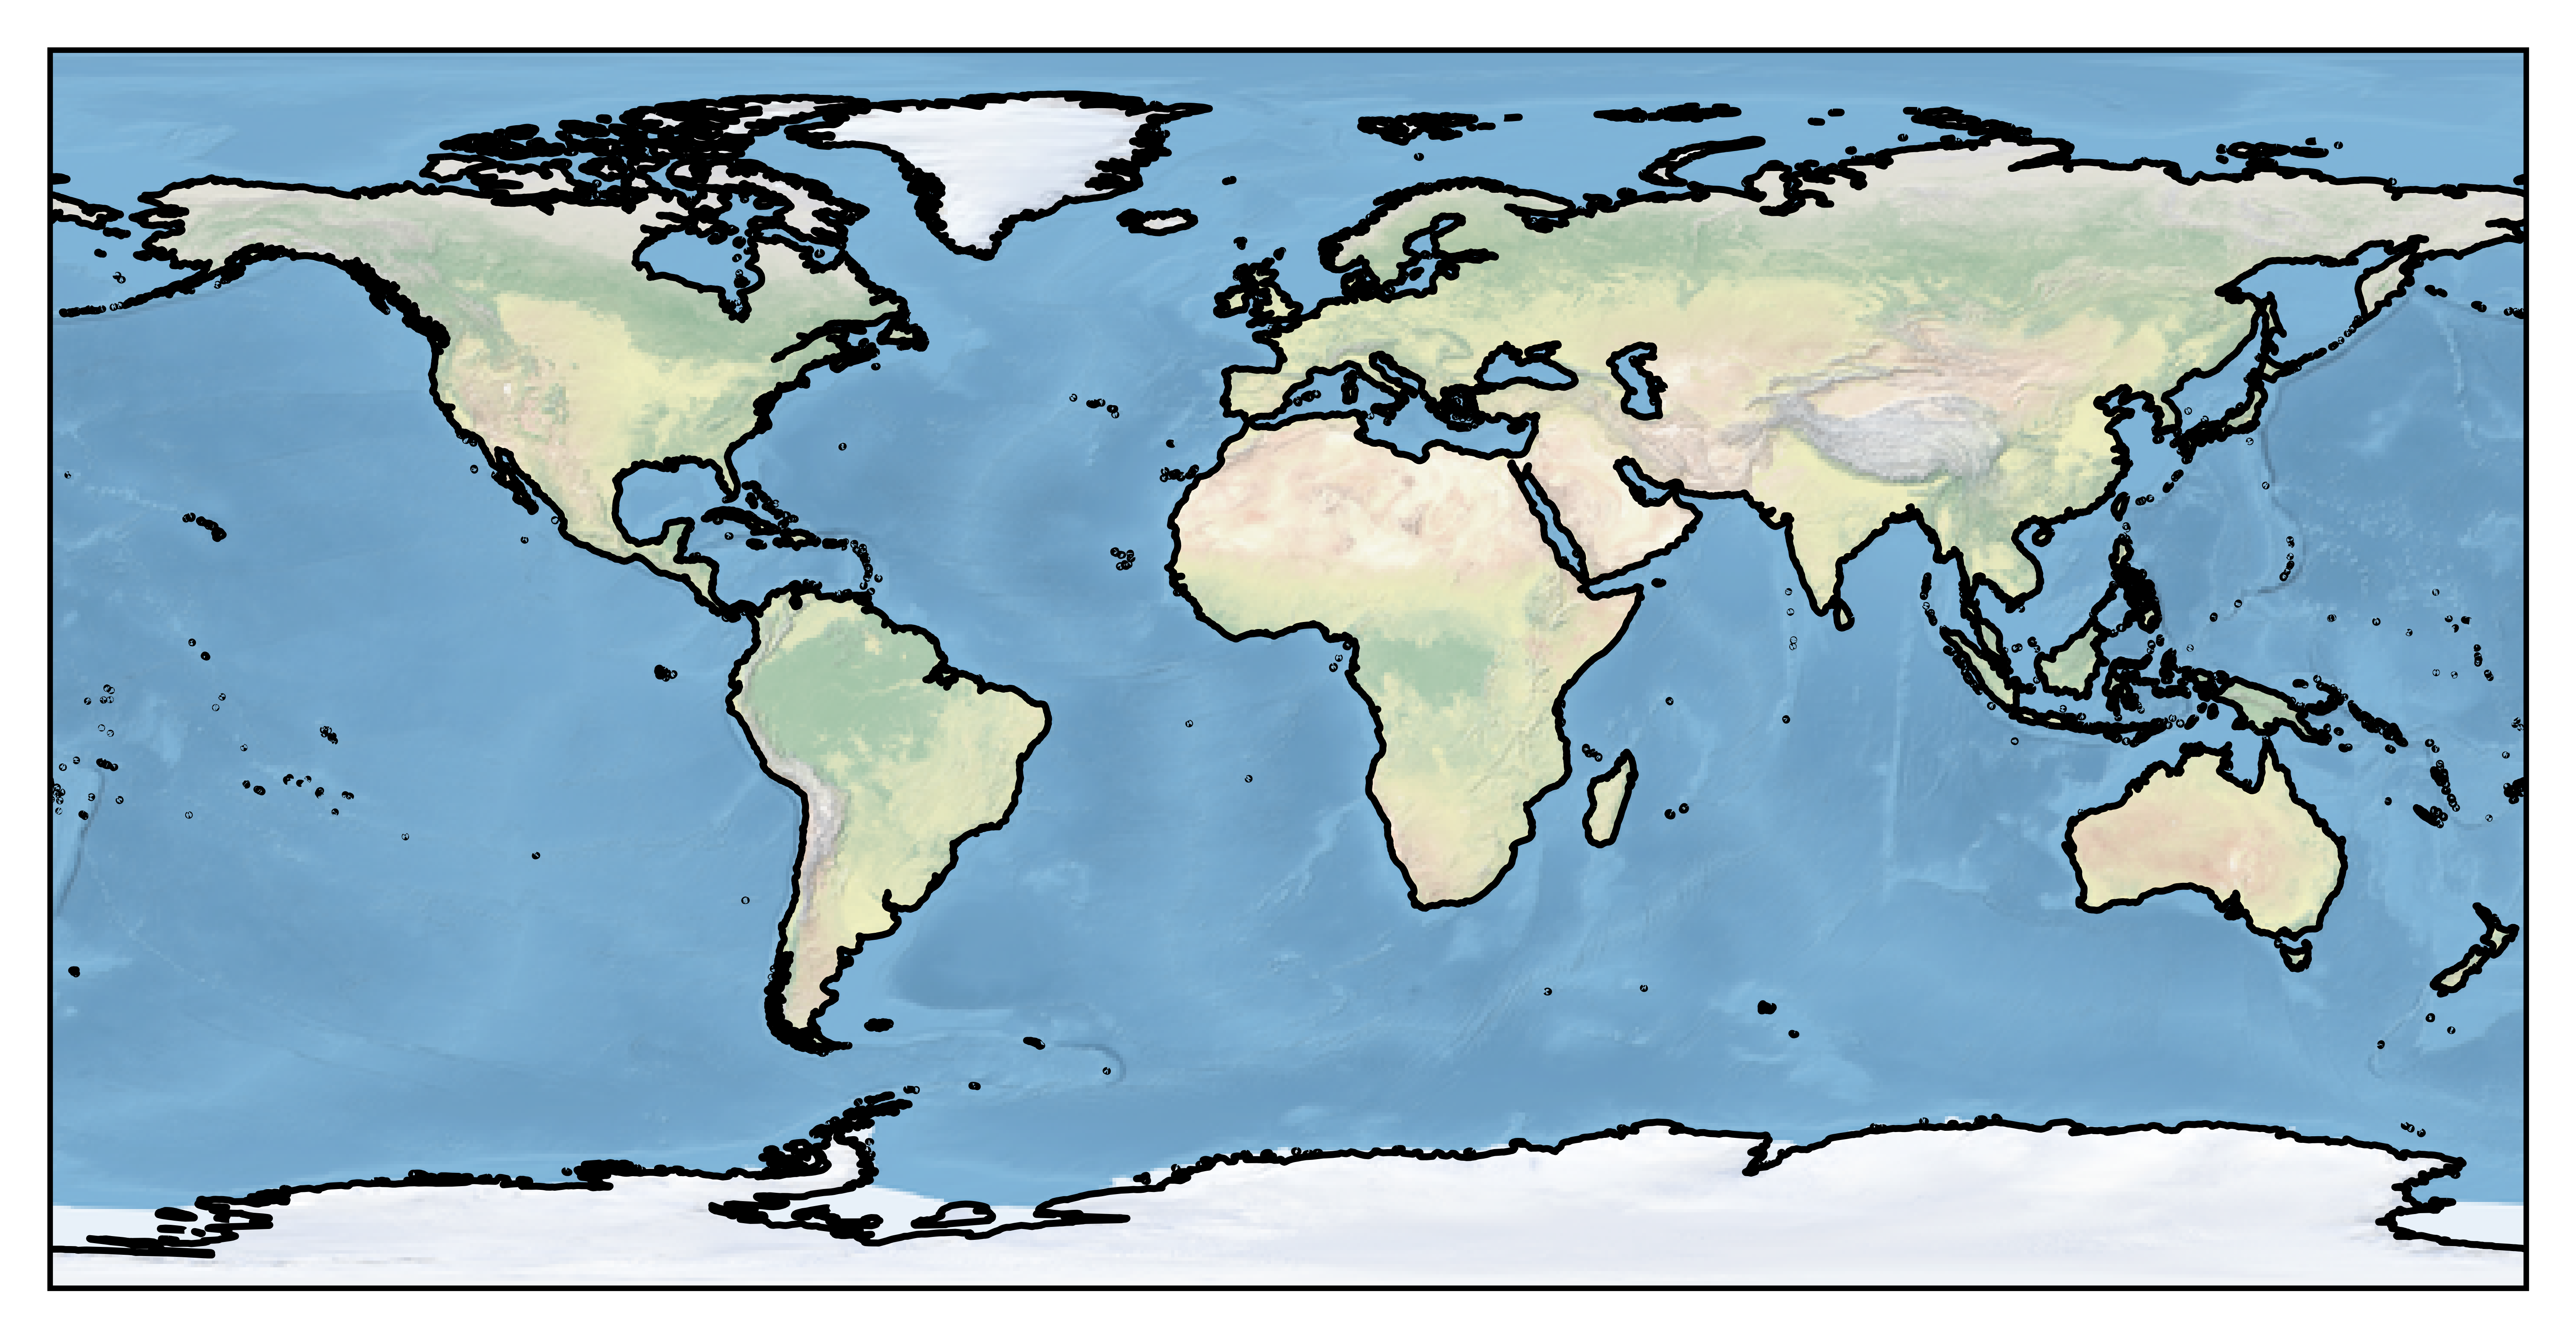

In [68]:
%load_ext autoreload
%autoreload 2
# 研究区域分析

import sys, math
sys.path.append('B://workspace/tensorflow/')

import numpy as np

from glob import glob
from cartopy import crs
from matplotlib import pyplot as plt
from cartopy.io import shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import colormaps
from matplotlib.colors import BoundaryNorm

from src.config.params import Areas

#%% 绘制地图投影

# 选择投影-常规
projection = crs.PlateCarree()
fig = plt.figure(dpi=1200)
ax = fig.add_subplot(1, 1, 1, projection = projection)
ax.set_global()
ax.stock_img()
ax.coastlines(resolution='50m')

#%% 加载深度数据

def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    
    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob('ne_10m_bathymetry_all/*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (-180, -90, 180, 90)  # (x0, y0, x1, y1)
        nei = shapereader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict

# Load data (14.8 MB file)
depths_str, shp_dict = load_bathymetry(
    'https://naturalearth.s3.amazonaws.com/' +
    '10m_physical/ne_10m_bathymetry_all.zip')

# Construct a discrete colormap with colors corresponding to each depth
depths = depths_str.astype(int)
depths = np.abs(depths)  # 将深度值转换为正数
N = len(depths)
nudge = 0.01
boundaries = [min(depths)] + sorted(depths+nudge)  # 从浅到深排序
norm = BoundaryNorm(boundaries, N)
blues_cm = colormaps['Blues'].resampled(N)  # 移除 '_r' 反转
colors_depths = blues_cm(norm(depths))

# 添加水深数据
for i, depth_str in enumerate(depths_str):
        ax.add_geometries(shp_dict[depth_str].geometries(),
                            crs=crs.PlateCarree(),
                            color=colors_depths[i])
        
# 添加研究区域
for area in Areas:
    # 获取研究区域的经纬度范围
    lon_start = area['lon'][0]
    lon_end = area['lon'][1] 
    lat_start = area['lat'][0]
    lat_end = area['lat'][1]
    
    x = [lon_start, lon_start,lon_end, lon_end, lon_start]
    y = [lat_start, lat_end, lat_end, lat_start, lat_start]
    
    # 绘制区域，并给区域加上 GMT 风格的黑白间隔边框
    # 绘制 GMT 风格的黑白间隔边框
    # 定义黑白间隔的线段长度(以度为单位)
    segment_length = 2.5

    # 遍历每个点对绘制黑白相间的边框
    for i in range(len(x)-1):
        # 计算当前线段的总长度
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        total_length = np.sqrt(dx**2 + dy**2)
        
        # 计算需要多少个线段
        n_segments = int(np.ceil(total_length/segment_length))
        
        # 计算每个小线段的x和y增量
        dx_segment = dx/n_segments
        dy_segment = dy/n_segments
        
        # 绘制黑白相间的线段
        for j in range(n_segments):
            x_start = x[i] + j*dx_segment
            y_start = y[i] + j*dy_segment
            x_end = x[i] + (j+1)*dx_segment
            y_end = y[i] + (j+1)*dy_segment
            
            color = 'black' if j % 2 == 0 else 'white'
            ax.plot([x_start, x_end], [y_start, y_end], 
                    color=color, linewidth=1, 
                    transform=crs.PlateCarree())
            
    ax.text(lon_start + 3, lat_end - 8, area['title'], transform=projection, fontdict={'fontsize': 6})


        
# 添加坐标
# 设置经纬度刻度
ax.set_xticks(np.arange(-180, 180 + 60, 60), crs=projection)
ax.set_xticks(np.arange(-180, 180 + 30, 30), minor=True, crs=projection)
ax.set_yticks(np.arange(-90, 90 + 30, 30), crs=projection)
ax.set_yticks(np.arange(-90, 90 + 15, 15), minor=True, crs=projection)

# 设置经纬度格式
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# 添加网格线
ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add custom colorbar
sm = plt.cm.ScalarMappable(cmap=blues_cm, norm=norm)
cb = fig.colorbar(mappable=sm,
                 ax=ax,
                 spacing='proportional',
                 extend='max',
                 orientation='horizontal',
                 fraction = 0.05,
                 pad=0.1
                 )

depths = depths[depths != 200]
# 选择较少的刻度点显示  # 每隔一个深度值显示一个刻度
cb.set_ticks(depths)

# 将刻度标签格式化为千米单位
tick_labels = [f'{int(d/1000)}k' if d >= 1000 else str(d) for d in depths]
cb.set_ticklabels(tick_labels)

cb.set_label(label='Depth (m)', fontsize=8)
cb.ax.tick_params(labelsize=6)

ax.set_rasterized(True)

plt.show()